In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Understand Data

1. Read data & base information
2. Distributions
3. Target variable
4. Corellation matrix

## 1.1 Read data & base information

In [2]:
train = pd.read_csv('train.csv')
#test = <<PUT_CODE_HERE>>

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


Questions:
1. how many rows (observations) and columns (features)?
2. do you see missing value?
3. what type of data do you see?

### Check [Five-number summary](https://en.wikipedia.org/wiki/Five-number_summary)

In [4]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Questions:
1. What is your target value (range value)?
2. Only this (point 1) we can treat like a target value?
3. Is there binary variable (e.g. 0 or 1)?
4. Is there categorical variable (e.g. red, blue, green)?
5. Is there numerical variable?

**Let's try to visualise distribution each features.**

## 1.2 Distributions

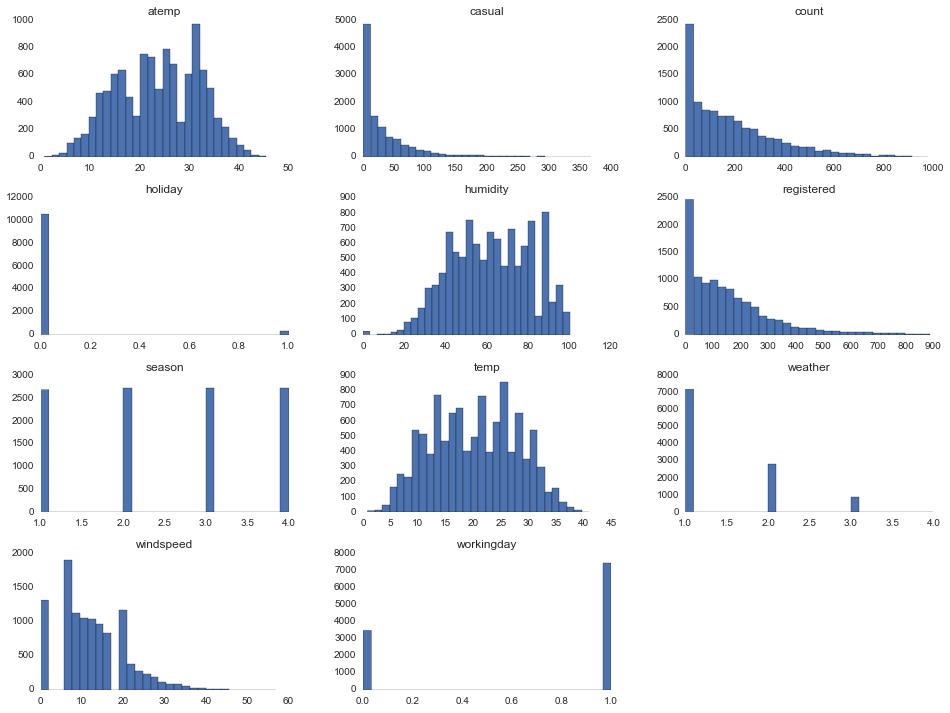

In [5]:
train.hist(figsize=(16,12),bins=30)
plt.show()

Questions:
1. what you can say about `atemp`?
2. ... `count`?
3. ... `weather`?
4. ... `season`?
5. ... `windspeed`?

## 1.3 Target variable
Questions
1. What is you target variable?
2. Can you do some transformation in order to get normal distribution?
3. What variables you can use for treat like target variable (but not straightforward)?
4. Do you need some transformation for this varibles (point 3)?

## 1.4 Correlation matrix

**Let's to see correlation matrix**

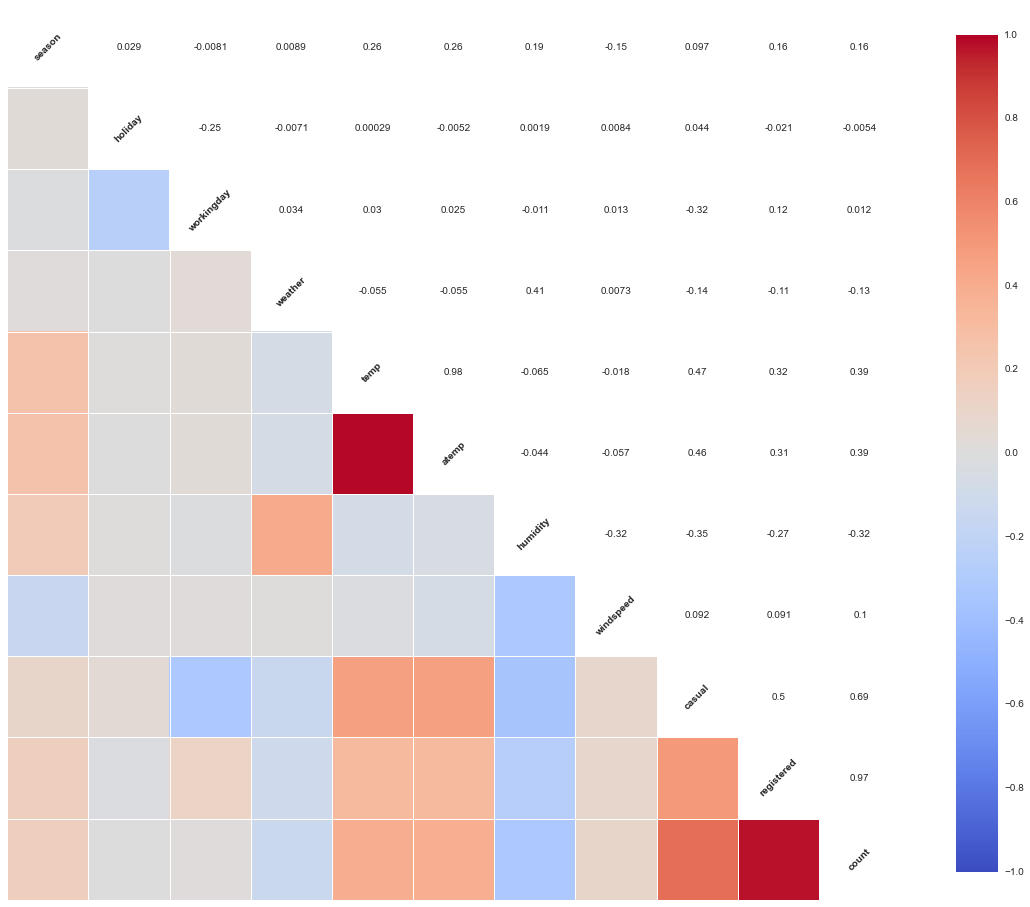

In [6]:
f, ax = plt.subplots(figsize=(20,20))
sns.corrplot(train, sig_stars=False, ax=ax)

Questions:
1. Is there correlation between variables?
2. ...inverse correlation?